In [239]:
# simulating amm in with different fee amounts
from functools import total_ordering
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt


In [240]:
def pretty_print_table(df):
    formatted_df = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for col in formatted_df.select_dtypes(include=['float', 'int']).columns:
        formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:,.4f}")
    print(formatted_df)

In [241]:
moe_asset = "USD"

time_interval = "5min"  # Choose from "1min", "5min", "30min", "daily"

pool_type = "cpmm"

"""
if pool_type == "mamm":
    asset_list = ["EUR"]
    total_pool = 600262.78
    specified_weights = {"EUR": 0.5}

elif pool_type == "cpmm":
    # Define multiple pool configurations

pools = [
    {"assets": ["USD", "EUR"], "weights": {"USD": 0.5, "EUR": 0.5}, "total_value": 600262.78},
    {"assets": ["USD", "GBP"], "weights": {"USD": 0.5, "GBP": 0.5}, "total_value": 253664.00},
    {"assets": ["USD", "CHF"], "weights": {"USD": 0.5, "CHF": 0.5}, "total_value": 102094.24},
]
"""
base_asset = "USD"
asset_list = ["GBP", "AUD", "CAD", "NZD"]
value_list = [475232.96, 234919.08, 228543.40, 61304.56]

print(f"Pool sum: {sum(value_list)}")

# Dynamically initialize pools
pools = []
for asset, value in zip(asset_list, value_list):
    pool = {
        "assets": [base_asset, asset],
        "weights": {base_asset: 0.5, asset: 0.5},
        "total_value": value
    }
    pools.append(pool)
    print(pool)


Pool sum: 1000000.0
{'assets': ['USD', 'GBP'], 'weights': {'USD': 0.5, 'GBP': 0.5}, 'total_value': 475232.96}
{'assets': ['USD', 'AUD'], 'weights': {'USD': 0.5, 'AUD': 0.5}, 'total_value': 234919.08}
{'assets': ['USD', 'CAD'], 'weights': {'USD': 0.5, 'CAD': 0.5}, 'total_value': 228543.4}
{'assets': ['USD', 'NZD'], 'weights': {'USD': 0.5, 'NZD': 0.5}, 'total_value': 61304.56}


In [242]:
"""

1min = 2m
5min = 3m
10min = 3m
30min = 1y
1h = 1y
daily = 20y

c = 1.05, 1.25, 1.5
order_size = 100, 1'000, 10'000
fees = ?

"""

"\n\n1min = 2m\n5min = 3m\n10min = 3m\n30min = 1y\n1h = 1y\ndaily = 20y\n\nc = 1.05, 1.25, 1.5\norder_size = 100, 1'000, 10'000\nfees = ?\n\n"

In [38]:
import pandas as pd

# Define the path to your Excel file
file_path = f"source/eikon source form3.xlsx"  # Update with actual filename

# Load both sheets into a dictionary of DataFrames
sheets = pd.read_excel(file_path, sheet_name=None)

# Check available sheets
print("Sheets in the Excel file:", sheets.keys())

time_interval = "5min"


# Load data from the "1D" sheet (Daily data)
full_df = sheets.get(time_interval)




Sheets in the Excel file: dict_keys(['1d', '1h', '30min', '10min', '5min', '1min', 'tick', 'Sheet8'])


In [39]:
currency_data = "JPY"

# Display first few rows of each to verify
#print(full_df.head(10))

selected_columns = full_df.iloc[3] == currency_data
#print(f"selected_columns", selected_columns)

# Filter only those columns
cleaned_df = full_df.loc[:, selected_columns]
print("cleaned_df")
print(cleaned_df.head(10))

# Reset index to drop unnecessary rows
cleaned_df = cleaned_df.iloc[6:].reset_index(drop=True)

# Rename columns properly (set first row as column names)
cleaned_df.columns = cleaned_df.iloc[0]
cleaned_df = cleaned_df[1:].reset_index(drop=True)
#print("cleaned_df dropped")
#print(cleaned_df.head(10))

# Drop fully NaN columns
cleaned_df = cleaned_df.dropna(axis=1, how="all")

# Drop "Bid High" and "Ask Low" columns
columns_to_drop = ["Bid Low", "Ask High"]
cleaned_df = cleaned_df.drop(columns=[col for col in columns_to_drop if col in cleaned_df.columns], errors="ignore")
#print("cleaned_df tidied")
#print(cleaned_df.head(10))

"""
# Split into Bid Low and Ask High DataFrames
bid_df = cleaned_df.iloc[:, [0, 1]].rename(columns={cleaned_df.columns[1]: "Bid Low"})
ask_df = cleaned_df.iloc[:, [2, 3]].rename(columns={cleaned_df.columns[2]: "Timestamp", cleaned_df.columns[3]: "Ask High"})

# Merge on Timestamp
final_cleaned_df = bid_df.merge(ask_df, on="Timestamp", how="outer")
print("final_cleaned_df")
print(final_cleaned_df.head(10))
"""

# Select only the required columns and rename them consistently
bid_low_df = pd.DataFrame(cleaned_df.iloc[:, [0, 1]].copy())  # Copy to avoid SettingWithCopyWarning
ask_high_df = pd.DataFrame(cleaned_df.iloc[:, [2, 3]].copy())  # Copy to avoid SettingWithCopyWarning

"""
print("bid")
print(bid_low_df)
print("ask")
print(ask_high_df)
"""


# Convert Timestamp to datetime for proper merging
bid_low_df["Timestamp"] = pd.to_datetime(bid_low_df["Timestamp"])
ask_high_df["Timestamp"] = pd.to_datetime(ask_high_df["Timestamp"])


# Drop any NaT (invalid datetime) values
bid_low_df = bid_low_df.dropna(subset=["Timestamp"])
ask_high_df = ask_high_df.dropna(subset=["Timestamp"])

"""
print("bid cleaned")
print(bid_low_df)
print("ask cleaned")
print(ask_high_df)
"""

# Perform an outer join to merge by Timestamp
final_cleaned_df = pd.merge(bid_low_df, ask_high_df, on="Timestamp", how="outer")

# Sort values to maintain chronological order
final_cleaned_df = final_cleaned_df.sort_values(by="Timestamp").reset_index(drop=True)
print(final_cleaned_df)

# Dynamically rename columns if they contain "Bid" or "Ask"
final_cleaned_df.columns = ["Bid" if "Bid" in col else "Ask" if "Ask" in col else col for col in final_cleaned_df.columns]

print("final_cleaned_df")
final_cleaned_df
#final_cleaned_df.to_csv("final_cleaned_df.csv", index=False)


cleaned_df
            Unnamed: 7 Unnamed: 8 Unnamed: 9          Unnamed: 10 Unnamed: 11  \
0                  NaN        NaN        NaN                  NaN         NaN   
1                    3        NaN        NaN                  NaN         NaN   
2                  JPY        NaN        NaN                  JPY         NaN   
3                  JPY        JPY        JPY                  JPY         JPY   
4                  BID        NaN        NaN                  ASK         NaN   
5                  NaN        NaN        NaN                  NaN         NaN   
6            Timestamp   Bid High    Bid Low            Timestamp    Ask High   
7  2025-01-25 00:00:00        156     155.93  2025-01-25 00:00:00      156.04   
8  2025-01-24 23:55:00     155.96     155.91  2025-01-24 23:55:00      155.97   
9  2025-01-24 23:50:00     155.92     155.86  2025-01-24 23:50:00      155.94   

  Unnamed: 12 Unnamed: 13  
0         NaN         NaN  
1         NaN         NaN  
2         NaN

,Timestamp,Bid,Ask
0,2024-10-27 20:05:00,152.38,152.34
1,2024-10-27 20:35:00,152.56,152.58
2,2024-10-27 20:45:00,152.7,152.75
3,2024-10-27 20:50:00,152.8,152.86
4,2024-10-27 20:55:00,152.92,152.86
...,...,...,...
18315,2025-01-24 23:40:00,155.92,155.92
18316,2025-01-24 23:45:00,155.92,155.89
18317,2025-01-24 23:50:00,155.92,155.88
18318,2025-01-24 23:55:00,155.96,155.93


In [243]:
time_col = "Local Time"
time_period_price_col = "Open"

# Define date ranges for each time interval
date_ranges = {
    "1min": ("22sep", "22dec"),
    "5min": ("22sep", "22dec"),
    "30min": ("22dec2023", "22dec"),
    "daily": ("22dec2004", "22dec"),
}

# Base directory for the historical data files
base_dir = "hist_bidask"

# Validate time interval and get the date range
if time_interval not in date_ranges:
    raise ValueError(f"Invalid time interval: {time_interval}. Choose from {list(date_ranges.keys())}.")

start_date, end_date = date_ranges[time_interval]

# Create a function to construct file paths dynamically
def get_file_path(asset, interval):
    return f"{base_dir}/{asset}_{start_date}_{end_date}_{interval}.xlsx"

# Load data for each asset
asset_data = {}
for asset in asset_list:
    file_path = get_file_path(asset, time_interval)
    print(f"Loading data from: {file_path}")  # Debug: Show the file path
    # Load the data
    data = pd.read_excel(file_path)

    # Drop unnecessary columns if they exist
    columns_to_drop = ["Local Date", "Refresh Rate", "BidNet"]
    data = data.drop(columns=[col for col in columns_to_drop if col in data.columns], errors="ignore")
    
    # Sort by date in ascending order and reset the index
    data = data.sort_values(by=time_col, ascending=True).reset_index(drop=True)

    # Handle special case for CHF (invert exchange rates)
    #if asset in ["CHF", "CAD", "JPY"]: # 1 currency buys x of usd
    if asset in ["AUD", "NZD", "EUR", "GBP"]: # 1 USD buys x of currency
        for col in ["Bid", "Ask", "High", "Low", "Open"]:
            if col in data.columns:
                data[col] = 1 / data[col]
    
    # Store the processed data
    asset_data[asset] = data
    
    # Debug: Verify the sorted data
    print(f"Asset: {asset}")
    print(asset_data[asset])  # Show the first few rows

# Example: Access EUR data
# eur_data = asset_data["EUR"]
# print(eur_data.head())  # Verify the loaded data
#print(asset_data["EUR"].head(1000))

Loading data from: hist_bidask/GBP_22sep_22dec_5min.xlsx
Asset: GBP
               Local Time       Bid       Ask      High       Low      Open
0     2024-09-23 00:35:00  0.750976  0.750525  0.750976  0.750976  0.750976
1     2024-09-23 00:45:00  0.750976  0.750525  0.750976  0.750976  0.750976
2     2024-09-23 00:50:00  0.750976  0.750469  0.750920  0.751033  0.750976
3     2024-09-23 00:55:00  0.751145  0.750638  0.750920  0.751145  0.750920
4     2024-09-23 01:00:00  0.751089  0.750582  0.751089  0.751089  0.751089
...                   ...       ...       ...       ...       ...       ...
18780 2024-12-20 23:40:00  0.795988  0.795545  0.795672  0.796052  0.795798
18781 2024-12-20 23:45:00  0.795862  0.795418  0.795672  0.796052  0.795988
18782 2024-12-20 23:50:00  0.795988  0.795482  0.795545  0.795988  0.795672
18783 2024-12-20 23:55:00  0.795735  0.795608  0.795735  0.796052  0.795735
18784 2024-12-21 00:00:00  0.795862  0.795292  0.795608  0.795925  0.795798

[18785 rows x 6 col

In [244]:
# Merge unique timestamps from both datasets and sort them
#unique_times = pd.concat([aapl_data['Time'], msft_data['Time']]).drop_duplicates().sort_values()
# Extract unique times from all assets dynamically
unique_times = pd.concat([data[time_col] for data in asset_data.values()]).drop_duplicates().sort_values().reset_index(drop=True)

# Print the sorted unique times for verification
print("Unique Times:")
print(unique_times)
#with pd.option_context('display.max_rows', None):   print(unique_times)

Unique Times:
0       2024-09-22 22:20:00
1       2024-09-22 22:25:00
2       2024-09-22 22:30:00
3       2024-09-22 22:35:00
4       2024-09-22 22:40:00
                ...        
19186   2024-12-20 23:40:00
19187   2024-12-20 23:45:00
19188   2024-12-20 23:50:00
19189   2024-12-20 23:55:00
19190   2024-12-21 00:00:00
Name: Local Time, Length: 19191, dtype: datetime64[ns]


In [245]:
def find_indexes_by_dates(df, start_date, end_date):
    # Convert the input dates to datetime
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    # Find the start index (earliest time not earlier than the start date)
    start_index = df.searchsorted(start_date, side='left')
    # Find the end index (latest time not exceeding the end date)
    end_index = df.searchsorted(end_date, side='right') - 1
    
    # Ensure the indexes are within valid range
    if start_index >= len(df):
        raise ValueError(f"Start date {start_date} is beyond the available data range.")
    if end_index < 0:
        raise ValueError(f"End date {end_date} is earlier than the available data range.")
    
    # Extract neighborhood entries
    start_neighbors = df[max(start_index - 2, 0): start_index + 3]
    end_neighbors = df[max(end_index - 2, 0): end_index + 3]
    
    # Return the indexes and neighborhood entries
    return start_index, end_index, start_neighbors, end_neighbors

# Example usage
start_date = "2024-10-01 00:00:00"
end_date = "2024-12-01 00:00:00"
start_idx, end_idx, start_neighbors, end_neighbors = find_indexes_by_dates(unique_times, start_date, end_date)

# Print results
print(f"Start index: {start_idx}, corresponding time: {unique_times.iloc[start_idx]}")
print(f"Start neighbors:\n{start_neighbors}")
print(f"End index: {end_idx}, corresponding time: {unique_times.iloc[end_idx]}")
print(f"End neighbors:\n{end_neighbors}")


Start index: 1771, corresponding time: 2024-10-01 00:00:00
Start neighbors:
1769   2024-09-30 23:50:00
1770   2024-09-30 23:55:00
1771   2024-10-01 00:00:00
1772   2024-10-01 00:05:00
1773   2024-10-01 00:10:00
Name: Local Time, dtype: datetime64[ns]
End index: 14743, corresponding time: 2024-11-30 00:00:00
End neighbors:
14741   2024-11-29 23:50:00
14742   2024-11-29 23:55:00
14743   2024-11-30 00:00:00
14744   2024-12-01 20:05:00
14745   2024-12-01 20:10:00
Name: Local Time, dtype: datetime64[ns]


In [246]:
manual_index = False

if manual_index:
    print("Manual indexing is enabled.")
    # Define manual start and end indices (default 0 for full range)
    manual_start_index = 42021  # Set to desired index, e.g., 4
    manual_end_index = 72594  # Set to desired index, e.g., 10

    # Print the corresponding times for manual indices
    print(f"Manual start index: {manual_start_index}, corresponding time: {unique_times.iloc[manual_start_index]}")
    print(f"Manual end index: {manual_end_index}, corresponding time: {unique_times.iloc[manual_end_index]}")
else:
    print("Automatic indexing is enabled.")
    # Find the start and end indices automatically
    start_index = unique_times[unique_times >= start_date].index[0]
    end_index = unique_times[unique_times <= end_date].index[-1]

    # Print results
    print(f"Automatic start index: {start_index}, corresponding time: {unique_times.iloc[start_index]}")
    print(f"Automatic end index: {end_index}, corresponding time: {unique_times.iloc[end_index]}")

    # Optionally, use these indices for further analysis
    manual_start_index = start_index
    manual_end_index = end_index
print()

# Validate and adjust the indices if out of range
if manual_start_index < 0 or manual_start_index >= len(unique_times):
    manual_start_index = 0
if manual_end_index < 0 or manual_end_index >= len(unique_times):
    manual_end_index = len(unique_times) - 1

# Get the corresponding times for the selected indices
period_start = unique_times.iloc[manual_start_index]
period_end = unique_times.iloc[manual_end_index]

# Filter unique times within the selected range
filtered_times = unique_times.iloc[manual_start_index:manual_end_index + 1].reset_index(drop=True)

# Print the selected period and filtered times for verification
print(f"Simulation Period: {period_start} to {period_end}")
print(filtered_times)

# Temporarily set pandas options to display all rows
#with pd.option_context('display.max_rows', None):   print(filtered_times)

Automatic indexing is enabled.
Automatic start index: 1771, corresponding time: 2024-10-01 00:00:00
Automatic end index: 14743, corresponding time: 2024-11-30 00:00:00

Simulation Period: 2024-10-01 00:00:00 to 2024-11-30 00:00:00
0       2024-10-01 00:00:00
1       2024-10-01 00:05:00
2       2024-10-01 00:10:00
3       2024-10-01 00:15:00
4       2024-10-01 00:20:00
                ...        
12968   2024-11-29 23:40:00
12969   2024-11-29 23:45:00
12970   2024-11-29 23:50:00
12971   2024-11-29 23:55:00
12972   2024-11-30 00:00:00
Name: Local Time, Length: 12973, dtype: datetime64[ns]


In [247]:
# data = {"EUR": eur_data} 
# print(data)

print("Used DataFrames for Simulation:")

filtered_asset_data = {}
for asset in asset_list:
    # Get the original data frame for the asset
    df = asset_data[asset]
    
    # Filter rows where the time column matches the filtered times
    filtered_df = df[df[time_col].isin(filtered_times)].reset_index(drop=True)
    filtered_asset_data[asset] = filtered_df
    
    # Print the asset name and the filtered data
    print(f"Asset: {asset}")
    #with pd.option_context('display.max_rows', None):   print(filtered_df)
    print(filtered_df)
    print()  # Add space between assets for clarity

Used DataFrames for Simulation:
Asset: GBP
               Local Time       Bid       Ask      High       Low      Open
0     2024-10-01 00:00:00  0.747943  0.747440  0.747608  0.747943  0.747719
1     2024-10-01 00:05:00  0.747943  0.747775  0.747719  0.748055  0.747943
2     2024-10-01 00:10:00  0.747999  0.747496  0.747943  0.747999  0.747999
3     2024-10-01 00:15:00  0.747831  0.747664  0.747719  0.748223  0.747999
4     2024-10-01 00:20:00  0.747831  0.747552  0.747552  0.747999  0.747887
...                   ...       ...       ...       ...       ...       ...
12725 2024-11-29 23:40:00  0.785299  0.784806  0.785053  0.785299  0.785176
12726 2024-11-29 23:45:00  0.785299  0.785114  0.785114  0.785484  0.785114
12727 2024-11-29 23:50:00  0.785238  0.784868  0.785176  0.785299  0.785238
12728 2024-11-29 23:55:00  0.785238  0.784868  0.785114  0.785361  0.785299
12729 2024-11-30 00:00:00  0.785114  0.784929  0.785114  0.785361  0.785361

[12730 rows x 6 columns]

Asset: AUD
       

In [248]:
starting_tables = []

for idx, pool in enumerate(pools):
    print(f"Running simulation for Pool {idx + 1}: {pool['assets']}")
    usd_weight = 1 - sum(pool["weights"].values())

    # Check if USD weight is valid
    if usd_weight < 0:
        raise ValueError(
            f"Invalid weights: the specified weights ({sum(pool["weights"].values())}) "
            f"exceed or equal 1, leaving no positive weight for USD."
        )

    # Add USD to the list of assets and its weight to the weights dictionary
    assets = pool["assets"]
    weights = pool["weights"]

    # Verify weights sum to 1 (debugging and validation)
    if abs(sum(weights.values()) - 1) > 1e-9:
        raise ValueError(
            f"Weights do not sum to 1. Current total: {sum(weights.values())}."
        )

    # Fetch spot prices for each asset
    # USD is always 1 (medium of exchange), others fetch dynamically
    '''spot_prices = {
        moe_asset: 1,  # USD as the medium of exchange
        "EUR": eur_data.iloc[0][time_period_price_col],
    }'''
    # Dynamically fetch spot prices for each asset
    spot_prices = {}
    for asset in assets:
        if asset == moe_asset:
            # Medium of exchange has a fixed spot price of 1
            spot_prices[asset] = 1
        else:
            # Fetch the spot price from the first entry of the corresponding filtered data frame
            spot_prices[asset] = filtered_asset_data[asset].iloc[0][time_period_price_col]


    starting_table = pd.DataFrame({
        "asset": assets,
        "weight": [weights[asset] for asset in assets],
        "spot": [spot_prices.get(asset, 1) for asset in assets],
    })

    starting_table["value"] = pool["total_value"] * starting_table["weight"]
    starting_table["balance"] = starting_table["value"] * starting_table["spot"]

    starting_table.set_index("asset", inplace=True)

    starting_tables.append(starting_table)

    #pretty_print_table(starting_table)
    #print()

for table in starting_tables:
    pretty_print_table(table)
    print()

Running simulation for Pool 1: ['USD', 'GBP']
Running simulation for Pool 2: ['USD', 'AUD']
Running simulation for Pool 3: ['USD', 'CAD']
Running simulation for Pool 4: ['USD', 'NZD']
       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  237,616.4800  237,616.4800
GBP    0.5000  0.7477  237,616.4800  177,670.4651

       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  117,459.5400  117,459.5400
AUD    0.5000  1.4465  117,459.5400  169,911.0950

       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  114,271.7000  114,271.7000
CAD    0.5000  1.3524  114,271.7000  154,541.0471

       weight    spot        value      balance
asset                                          
USD    0.5000  1.0000  30,652.2800  30,652.2800
NZD    0.5000  1.5753  30,652.2800  48,286.5154



In [249]:
# Fee values for different scenarios
fee_values = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]
order_sizes = [100, 1000, 10000]
#fee_values = [1]
#order_sizes = [100, 1000]

base_asset = starting_table.index[0]
if True:
  print(f"Base asset: {base_asset}")

  for table in starting_tables:
    for asset in starting_table.index:
      print(asset)

Base asset: USD
USD
NZD
USD
NZD
USD
NZD
USD
NZD


In [250]:
#Calculate invariant based on balances and weights.
def calculate_invariant(inv_table):
    #inv = 1
    #for asset in assets:
    #    inv *= balances[asset] ** weights[asset]
    #for asset in assets_table.items():
        #inv *= asset["balance"] ** asset["weight"]
    #return inv
    return (inv_table["balance"] ** inv_table["weight"]).prod()

In [251]:
def print_pool_standing(info_table):
    #pd.DataFrame(info_table)
    print(f"Assets: {info_table.index}")
    #print(f"Weights: {weights}")
    print(f"Balances: {info_table["balance"]}")
    print(f"Inv: {calculate_invariant(info_table)}")
    #print("Values: ")
    total_pool_value = 0
    #for asset in assets:
        #total_pool_value += balances[asset] * opens[asset]
        #print("Asset ", asset, " value: ", balances[asset] * opens[asset])
        #inv *= balances[asset] ** weights[asset])
    print(f"Total pool value: {info_table["value"].sum()}")

In [252]:
matrix_list = []  # To store the matrix for each pool as a list
starting_tables_named = [] # Add an index to the starting tables

for table in starting_tables:
    pool_name = "/".join(table.index)
    starting_tables_named.append({"pool_name": pool_name, "table": table})
    pretty_print_table(table)
    historical_values_df = {}
    daily_pool_values = {}  # Dictionary to store USD values for each date

    hist_hold_table = table.copy()
    # Append the new variation's data to the DataFrame
    if 'historical_values_df' not in globals():
        # Initialize DataFrame if it doesn't exist
        historical_values_df = pd.DataFrame()

    # Get the first date in filtered_times
    first_date = pd.to_datetime(filtered_times.iloc[0]).date()

    # Calculate the previous date
    before_start_date = first_date - pd.Timedelta(days=1)

    # Append the previous date with a value of 0 to daily_pool_values
    daily_pool_values[before_start_date] = 0
    #print(f"Appended initial value for {before_start_date}: {daily_pool_values}")
    initial_value = sum(hist_hold_table["value"])

    for time_index, time in enumerate(filtered_times):
        current_date = time.date()  # Extract the current date from the timestamp
        next_date = filtered_times[time_index + 1].date() if time_index + 1 < len(filtered_times) else None

        if current_date != next_date:  # The day is rolling over
            for asset in hist_hold_table.index:
                if asset == base_asset:
                    #open_prices[asset] = spots["USD"]
                    #last_close_prices[asset] = spots["USD"]
                    pass
                else:
                    #print(asset)
                    #print(time)
                    
                    asset_df = asset_data[asset]
                    row = asset_df[asset_df[time_col] == time]                    
                    if row.empty:  # Handle missing data by checking the previous entry
                        valid_rows = asset_df[asset_df[time_col] <= time]
                        if not valid_rows.empty:
                            row = valid_rows.iloc[[-1]]  # Take the latest valid entry

                    if not row.empty:
                        hist_hold_table.at[asset, "spot"] = row["Open"].values[0]

                    #print(row)
                    hist_hold_table.at[asset, "spot"] = row["Open"].values[0]
                hist_hold_table.at[asset, "value"] = hist_hold_table.at[asset, "balance"] / hist_hold_table.at[asset, "spot"]
        
            #pool_value = hist_hold_table["value"].sum() - total_pool  # Calculate total value of the pool in USD
            #daily_pool_values[current_date] = pool_value  # Append the value for the day
            daily_pool_values[current_date] = hist_hold_table["value"].sum() - initial_value
            #print(f"Appended return for {current_date}: {pool_value}")


    # Ensure the last day is recorded
    if current_date not in daily_pool_values:
        daily_pool_values[current_date] = hist_hold_table["value"].sum() - initial_value

    #historical_values.append(pd.Series(daily_pool_values))

    #historical_values_df["hold"] = pd.Series(daily_pool_values)
    #print(historical_values_df)
    # Create a DataFrame for this pool's "hold" scenario
    
    print(pool_name)
    matrix = {
        "pool_name": pool_name,
        "data": pd.DataFrame({"date": list(daily_pool_values.keys()), "hold": list(daily_pool_values.values())}).set_index("date")
    }
    matrix_list.append(matrix)

# Combine historical values for all pools into a DataFrame
#historical_values_df = pd.concat(historical_values, axis=1)
#historical_values_df.columns = [f"Pool {i + 1}" for i in range(len(pools))]
#historical_values_df.columns = ["/".join(pool['assets']) for pool in pools]  # Use both asset names as column name

#print("Historical Values for All Pools:")
#print(historical_values_df)

# Print the list of matrices
for matrix in matrix_list:
    print(f"Matrix for {matrix['pool_name']}:")
    print(matrix['data'])


       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  237,616.4800  237,616.4800
GBP    0.5000  0.7477  237,616.4800  177,670.4651
USD/GBP
       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  117,459.5400  117,459.5400
AUD    0.5000  1.4465  117,459.5400  169,911.0950
USD/AUD
       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  114,271.7000  114,271.7000
CAD    0.5000  1.3524  114,271.7000  154,541.0471
USD/CAD
       weight    spot        value      balance
asset                                          
USD    0.5000  1.0000  30,652.2800  30,652.2800
NZD    0.5000  1.5753  30,652.2800  48,286.5154
USD/NZD
Matrix for USD/GBP:
                    hold
date                    
2024-09-30      0.000000
2024-10-01  -1599.034186
2024-10-02  -1883.306930
2024-10-03  -4495.062767
2024-1

In [253]:
print(starting_tables_named)

[{'pool_name': 'USD/GBP', 'table':        weight      spot      value        balance
asset                                            
USD       0.5  1.000000  237616.48  237616.480000
GBP       0.5  0.747719  237616.48  177670.465082}, {'pool_name': 'USD/AUD', 'table':        weight     spot      value        balance
asset                                           
USD       0.5  1.00000  117459.54  117459.540000
AUD       0.5  1.44655  117459.54  169911.095038}, {'pool_name': 'USD/CAD', 'table':        weight    spot     value       balance
asset                                        
USD       0.5  1.0000  114271.7  114271.70000
CAD       0.5  1.3524  114271.7  154541.04708}, {'pool_name': 'USD/NZD', 'table':        weight      spot     value       balance
asset                                          
USD       0.5  1.000000  30652.28  30652.280000
NZD       0.5  1.575299  30652.28  48286.515438}]


In [254]:
results_summary = {}
for table in starting_tables:
    pool_name = "/".join(table.index)
    print(pool_name)
    results = []
    result_tables = []
    direction = {}
    # last_date = None  # To track the last recorded date

    #sim_table = starting_table
    initial_value = sum(table["value"])
    starting_table = table
    for order_size in order_sizes:
        print(f"Order Size simulation: {order_size}")
        # Loop through each fee variation
        for fee_percentage in fee_values:
            print(f"Fee % simulation: {fee_percentage}")
            sim_table = starting_table.copy()
            trades = 0
            fees_earned = 0
            fee = fee_percentage / 100
            # Initialize balances and invariant
            #balances = {asset: (initial_pool * weights[asset]) / spots[asset] for asset in assets}


            trades_log = []
            end_of_period_values = []

            # Loop through each unique time period
            # Fetch data for each asset at the current time and update last close prices if needed
            open_prices = {}
            last_close_prices = {}
            #open_prices[asset] = spots["USD"]
            #last_close_prices[asset] = spots["USD"]
            times = 0
            missing_data_log = {}
            
            daily_pool_values[before_start_date] = 0
            if False:
                print(f"Appended initial value for {before_start_date}: {daily_pool_values[before_start_date]}")

            for time_index, time in enumerate(filtered_times):
                current_date = time.date()  # Extract the current date from the timestamp
                next_date = filtered_times[time_index + 1].date() if time_index + 1 < len(filtered_times) else None

                '''times += 1
                if times > 2:
                    break'''
                #if trades > 10:
                    #rint("breaking")
                    #break

                if False:
                    print(time)
                    if False:
                        print(sim_table)
                if False:
                    print("Current date: ", current_date)
                    print("Next date: ", next_date)
                missing_data_assets = set()
                #
                for asset in sim_table.index:
                    if asset == base_asset:
                        #open_prices[asset] = spots["USD"]
                        #last_close_prices[asset] = spots["USD"]
                        pass
                    else:
                        direction[asset] = None
                        #asset_data = data[asset]
                        #row = asset_data[asset_data[time_col] == time]
                        asset_df = asset_data[asset]
                        row = asset_df[asset_df[time_col] == time]
                        if row.empty:
                            if False:
                                print(f"No data for asset {asset} at time {time}")
                            missing_data_assets.add(asset)  # Flag the asset
                            # Log the missing data for later analysis
                            if time not in missing_data_log:
                                missing_data_log[time] = []
                            missing_data_log[time].append(asset)
                            continue
                        else:
                            #sim_table.at[asset, "spot"] = row[time_period_price_col].values[0]
                            sim_table.at[asset, "spot"] = row["Open"].values[0]
                            sim_table.at[asset, "value"] = sim_table.at[asset, "balance"] / sim_table.at[asset, "spot"]

                            # Define `market_bid` and `market_ask` once for the current time and asset
                            market_bid = row['Bid'].values[0]
                            market_ask = row['Ask'].values[0]
                            
                            sim_table.at[asset, "market_bid"] = market_bid  # Optional: Store for later use
                            sim_table.at[asset, "market_ask"] = market_ask  # Optional: Store for later use

                            if False:
                                print(f"Asset: {asset}")
                                print(row)
                                
                                print(f"1 {moe_asset} (MOE) = bid: {market_bid}, ask: {market_ask}")
                                #print(f"Market bid: {1 / market_bid}, Market ask: {1 / market_ask} (in terms of MOE)")
                        '''if not row.empty:
                            sim_table.at[asset, "spot"] = row['Open'].values[0]
                            last_close_prices[asset] = row['Close'].values[0]
                        else:
                            open_prices[asset] = sim_table.at[asset, "spot"]'''
                            

                # Trading loop for each asset
                continue_trading = True
                while continue_trading:
                    continue_trading = False

                    for asset in sim_table.index:
                        if asset == base_asset or asset in missing_data_assets:  # Skip flagged assets for this time
                            continue

                        #print(asset)
                        market_bid = sim_table.at[asset, "market_bid"]
                        market_ask = sim_table.at[asset, "market_ask"]

                        '''
                        # Fetch high and low prices for the asset
                        row = asset_df[asset][asset_df[asset][time_col] == time]
                        if not row.empty:
                            #high_price = row['High'].values[0]
                            #low_price = row['Low'].values[0]
                            market_bid = row['Bid'].values[0]
                            market_ask = row['Ask'].values[0]

                            # Calculate bid and ask prices for the current asset
                            other_balances_product = 1
                            for other_asset in assets:
                                if other_asset != asset and other_asset != "USD":
                                    #print("other asset: ", other_asset, " balance: ", balances[other_asset], " weight: ", weights[other_asset])
                                    other_balances_product *= balances[other_asset] ** weights[other_asset]

                            inv = calculate_invariant(balances, weights)'''
                        #inv = calculate_invariant(sim_table)
                        balance = sim_table.at[asset, "balance"]
                        weight = sim_table.at[asset, "weight"]

                        moe_balance = sim_table.at[base_asset, "balance"]
                        moe_weight = sim_table.at[base_asset, "weight"]
                        
                        if False:
                            print(f"Balance: {balance}, weight: {weight}")
                            other_balances_product = inv / (balance ** weight)
                            print(f"Inv: {inv}, Other bal product: {other_balances_product}")
                        #print("other asset balances produt: ", other_balances_product)
                        #print("balance of the asset: ", balances[asset])
                        #print("invariant: ", balances[asset]**weights[asset] * other_balances_product)

                        #bid_amount_wo_fee = abs(((inv / ((balance + order_size) ** weight * other_balances_product)) ** (1 / sim_table.at["USD", "weight"]) - sim_table.at["USD", "balance"]))
                        #ask_amount_wo_fee = abs(((inv / ((balance - order_size) ** weight * other_balances_product)) ** (1 / sim_table.at["USD", "weight"]) - sim_table.at["USD", "balance"]))

                        #bid_amount_wo_fee = sim_table.at["USD", "balance"] - (((sim_table.at["USD", "balance"]**sim_table.at["USD", "weight"] * balance**weight) / ((balance + order_size)**weight)))**(1 / sim_table.at["USD", "weight"])
                        #ask_amount_wo_fee = -sim_table.at["USD", "balance"] + (((sim_table.at["USD", "balance"]**sim_table.at["USD", "weight"] * balance**weight) / ((balance - order_size)**weight)))**(1 / sim_table.at["USD", "weight"])
                        

                        #bid_amount_wo_fee = moe_balance - (((moe_balance**moe_weight * balance**weight) / ((balance + order_size)**weight)))**(1 / moe_weight)
                        #ask_amount_wo_fee = -moe_balance+ (((moe_balance**moe_weight * balance**weight) / ((balance - order_size)**weight)))**(1 / moe_weight)

                        bid_amount_wo_fee = balance - (((moe_balance**moe_weight * balance**weight) / ((moe_balance + order_size)**moe_weight)))**(1 / weight)
                        ask_amount_wo_fee = -balance+ (((moe_balance**moe_weight * balance**weight) / ((moe_balance - order_size)**moe_weight)))**(1 / weight)

                        if False:
                            print(f"1 {moe_asset} (MOE) = bid: {market_bid}, ask: {market_ask}")
                            print(asset, " bid (wo fee): ", bid_amount_wo_fee)
                            print(asset, " ask (wo fee): ", ask_amount_wo_fee)
                        
                        bid_amount = bid_amount_wo_fee * (1 - fee)
                        ask_amount = ask_amount_wo_fee * (1 + fee)

                        bid_price = bid_amount / order_size
                        ask_price = ask_amount / order_size

                        if False:
                            print(asset, " bid: ", bid_price)
                            print(asset, " ask: ", ask_price)

                        # Sell asset
                        if market_bid > ask_price and direction[asset] != "buy":
                            if balance >= order_size:
                                direction[asset] = "sell"
                                trades += 1
                                if False:
                                    print("Trade: ", trades)
                                    pretty_print_table(sim_table)
                                    #trades_log.append({'Time': time, 'Asset': asset, 'Action': 'Sell', 'Shares': 1, 'Price': ask_price})
                                    #print({'Time': time, 'Asset': asset, 'Action': 'Sell', 'Shares': 1, 'Price': ask_price})
                                    #trade_printout = {'Time': time, 'Asset': asset, 'Action': 'Sell', 'Quantity': order_size, 'Amount': round(float(ask_amount), 4), 'Price': round(float(ask_amount_wo_fee), 4)}
                                    #trade_printout = {'Time': time, "Sold": {ask_amount}, "of": {asset}, "for": {order_size}, "of": {moe_asset}, f"(exch: {ask_price})": None}
                                    '''trade_printout = {
                                        "Time": str(time),
                                        "Bought": f"{float(ask_amount):.2f}",
                                        "of": asset,
                                        "for": f"{order_size}",
                                        "of": moe_asset,
                                        "Exchange Rate": f"{float(ask_price):.4f}"
                                    }'''
                                    trade_printout = f"[At: {time}] Bought {float(ask_amount):.4f} {asset} for {order_size} {moe_asset} (exch: {float(ask_price):.4f})"
                                    trades_log.append(trade_printout)
                                    print(trade_printout)

                                sim_table.at[base_asset, "balance"] -= order_size
                                sim_table.at[asset, "balance"] += ask_amount

                                sim_table.at[base_asset, "value"] = sim_table.at[base_asset, "balance"]
                                sim_table.at[asset, "value"] = sim_table.at[asset, "balance"] / sim_table.at[asset, "spot"]
                                fees_earned += (ask_amount - ask_amount_wo_fee) / sim_table.at[asset, "spot"]

                                #inv = calculate_invariant(sim_table)
                                if False:
                                    print(f"Fee earned: {round((ask_amount - ask_amount_wo_fee) / sim_table.at[asset, "spot"], 4)} {moe_asset} (total: {round(fees_earned, 4)} {moe_asset}), {asset} fee: {ask_amount - ask_amount_wo_fee}, With fee: {round(ask_amount, 4)}, without fee {round(ask_amount_wo_fee, 4)}")
                                    pretty_print_table(sim_table)
                                    print()
                                continue_trading = True  # Check for more trades within the period
                                break

                        # Buy asset
                        elif market_ask < bid_price and direction[asset] != "sell":
                            if moe_balance >= bid_price:
                                direction[asset] = "buy"

                                trades += 1
                                if False:
                                    print("Trade: ", trades)
                                    pretty_print_table(sim_table)
                                    #trade_printout = {'Time': time, 'Asset': asset, 'Action': 'Buy', 'Quantity': order_size, 'Amount': round(float(bid_amount), 4), 'Price': round(float(bid_price), 4)}
                                    #trade_printout = {'Time': time, "Bought": {ask_amount}, "of": {asset}, "for": {order_size}, "of": {moe_asset}, f"(exch: {bid_price})": None}
                                    '''trade_printout = {
                                        "Time": str(time),
                                        "Bought": f"{float(bid_amount):.2f}",
                                        "of": asset,
                                        "for": f"{order_size}",
                                        "of": moe_asset,
                                        "Exchange Rate": f"{float(bid_price):.4f}"
                                    }'''
                                    trade_printout = f"[At: {time}] Sold {float(bid_amount):.4f} {asset} for {order_size} {moe_asset} (exch: {float(bid_price):.4f})"
                                    trades_log.append(trade_printout)
                                    print(trade_printout)
                                sim_table.at[base_asset, "balance"] += order_size
                                sim_table.at[asset, "balance"] -= bid_amount

                                sim_table.at[base_asset, "value"] = sim_table.at[base_asset, "balance"]
                                sim_table.at[asset, "value"] = sim_table.at[asset, "balance"] / sim_table.at[asset, "spot"]

                                fees_earned += (bid_amount_wo_fee - bid_amount) / sim_table.at[asset, "spot"]

                                #inv = calculate_invariant(balances, weights)
                                if False:
                                    #print(f"Fee earned: {round(bid_amount_wo_fee - bid_amount, 4)} (total: {round(fees_earned, 4)}), With fee: {round(bid_amount, 4)}, without fee {round(bid_amount_wo_fee, 4)}")
                                    print(f"Fee earned: {round((bid_amount_wo_fee - bid_amount) / sim_table.at[asset, "spot"], 4)} {moe_asset} (total: {round(fees_earned, 4)} {moe_asset}), {asset} fee: {bid_amount_wo_fee - bid_amount}, With fee: {round(bid_amount, 4)}, without fee {round(bid_amount_wo_fee, 4)}")
                                    pretty_print_table(sim_table)
                                    print()
                                continue_trading = True  # Check for more trades within the period
                                break

                '''for asset in sim_table.index:
                    if asset == base_asset:
                        pass
                    else:
                        row = asset_df[asset_df[time_col] == time
                        # sim_table.at[asset, "spot"] = row['Close'].values[0]

                        sim_table.at[asset, "value"] = sim_table.at[asset, "balance"] / sim_table.at[asset, "spot"]'''

                # Calculate end-of-period pool value
                '''pool_value = balances["USD"]
                il_formula_end_value = 1
                for asset in assets:
                    if asset != "USD":
                        pool_value += balances[asset] * last_close_prices[asset]
                        il_formula_end_value *= (last_close_prices[asset] / )
                end_of_period_values.append(pool_value)'''
                end_of_period_values.append(sim_table["value"].sum())
                # Check if this is the last timestamp for the day
                if current_date != next_date:  # The day is rolling over
                    #pretty_print_table(sim_table)
                    #if current_date in 
                    pool_value = sim_table["value"].sum()  # Calculate total value of the pool in USD
                    daily_pool_values[current_date] = pool_value - initial_value  # Append the value for the day
                    if False:
                        print(f"Appended return for {current_date}: {daily_pool_values[current_date]}")

            # Record the final pool value for the current fee
            final_pool_value = end_of_period_values[-1]
            results.append({'Order Size': order_size, 'Fee %': fee_percentage, 'Final_Pool_Value': final_pool_value, "Fees": fees_earned, "Trades": trades})
            result_tables.append(sim_table)

            # Ensure the last day is recorded
            if current_date not in daily_pool_values:
                pool_value = sim_table["value"].sum()
                daily_pool_values[current_date] = pool_value - initial_value
                print(f"Appended return for {current_date}: {daily_pool_values[current_date]}")

            #print(daily_pool_values)
            variation_name = f"s: {order_size}, %: {fee_percentage}"

            #historical_values_df[variation_name] = pd.Series(daily_pool_values)
            #print(historical_values_df)
            # Find the correct matrix in matrix_list
            for matrix in matrix_list:
                if matrix["pool_name"] == pool_name:
                    # Append the variation data to the matrix
                    matrix["data"][variation_name] = pd.Series(daily_pool_values)
                    break  # Exit the loop once the correct matrix is found


    # Convert results to DataFrame for comparison
    results_df = pd.DataFrame(results)
    print(results_df)
    results_summary[pool_name] = pd.DataFrame(results)





USD/GBP
Order Size simulation: 100
Fee % simulation: 0.1
Fee % simulation: 0.5
Fee % simulation: 1
Fee % simulation: 1.5
Fee % simulation: 2
Fee % simulation: 2.5
Fee % simulation: 3
Order Size simulation: 1000
Fee % simulation: 0.1
Fee % simulation: 0.5
Fee % simulation: 1
Fee % simulation: 1.5
Fee % simulation: 2
Fee % simulation: 2.5
Fee % simulation: 3
Order Size simulation: 10000
Fee % simulation: 0.1
Fee % simulation: 0.5
Fee % simulation: 1
Fee % simulation: 1.5
Fee % simulation: 2
Fee % simulation: 2.5
Fee % simulation: 3
    Order Size  Fee %  Final_Pool_Value        Fees  Trades
0          100    0.1     463749.704412   45.495725     455
1          100    0.5     463756.998069   51.856397     104
2          100    1.0     463776.713484   67.355312      68
3          100    1.5     463797.390912   91.661406      62
4          100    2.0     463815.081873  109.849729      56
5          100    2.5     463829.831162  121.999637      50
6          100    3.0     463843.582671  131

In [255]:
"""
# Get the next usable date
max_date = filtered_times.max()
next_date = unique_times.iloc[unique_times[unique_times == max_date].index[0] + 1]

# Get the latest spot price before or on the next usable date
spot = asset_data["EUR"].loc[asset_data["EUR"]["Local Time"] <= next_date, "Open"].iloc[-1]

print(f"Spot price: {spot}")
"""


'\n# Get the next usable date\nmax_date = filtered_times.max()\nnext_date = unique_times.iloc[unique_times[unique_times == max_date].index[0] + 1]\n\n# Get the latest spot price before or on the next usable date\nspot = asset_data["EUR"].loc[asset_data["EUR"]["Local Time"] <= next_date, "Open"].iloc[-1]\n\nprint(f"Spot price: {spot}")\n'

In [256]:
print(f"Base asset: {base_asset}")
print()

# Print the summary for each pool
end_spot_for_summary = {}
combined_summary = None
if True:
    for pool_name, summary_df, in results_summary.items():
        print(f"Summary for {pool_name}:")
        # Find the respective starting table for the pool_name
        starting_table_entry = next(
            table_entry for table_entry in starting_tables_named if table_entry["pool_name"] == pool_name
        )
        starting_table = starting_table_entry["table"]
        print("Starting table (V0):")
        pretty_print_table(starting_table)
        print("   Value:               ", f"{starting_table['value'].sum():,.4f}")
        print()

        print("Hold table (VH):")
        hold_table = starting_table.copy()
        for asset in hold_table.index:
            #print(asset)
            if asset != base_asset:
                # Get the next usable date
                max_date = filtered_times.max()
                next_date = unique_times.iloc[unique_times[unique_times == max_date].index[0] + 1]

                # Get the latest spot price before or on the next usable date
                end_spot_for_summary[asset] = asset_data[asset].loc[asset_data[asset]["Local Time"] <= next_date, "Open"].iloc[-1]

                print(f"Spot price: {end_spot_for_summary[asset]:,.4f}")
                #hold_table['spot'][asset] = end_spot_for_summary[asset]
                hold_table.loc[asset, "spot"] = end_spot_for_summary[asset]
        hold_table['value'] = hold_table['balance'] / hold_table['spot']
        pretty_print_table(hold_table)
        print("   Value:               ", f"{hold_table['value'].sum():,.4f}")
        print()

        print(summary_df)
        print()

        # Combine the summaries
        if combined_summary is None:
            combined_summary = summary_df.copy()
        else:
            combined_summary["Final_Pool_Value"] += summary_df["Final_Pool_Value"]
            combined_summary["Fees"] += summary_df["Fees"]
            combined_summary["Trades"] += summary_df["Trades"]

        print()

from collections import OrderedDict

if True:
    print("Combined")
    # Combine the starting tables while preserving the order of assets
    combined_starting_table = pd.concat(
        [entry["table"] for entry in starting_tables_named], axis=0
    )

    # Use OrderedDict to drop duplicates while preserving the order
    ordered_assets = OrderedDict.fromkeys(combined_starting_table.index)

    # Convert OrderedDict keys to a list
    ordered_assets_list = list(ordered_assets.keys())

    # Filter the combined table to match the ordered assets
    combined_starting_table = combined_starting_table.loc[ordered_assets_list]

    # Group by the asset to sum the values and balances, keeping spot rates and recalculating weights
    combined_starting_table = combined_starting_table.groupby(level=0, sort=False).agg(
        {
            "weight": "sum",  # We'll recalculate this later
            "spot": "first",  # Keep the original spot rates
            "value": "sum",  # Sum the values across tables
            "balance": "sum",  # Sum the balances across tables
        }
    )

    # Recalculate weights based on the new total value
    total_value = combined_starting_table["value"].sum()
    combined_starting_table["weight"] = combined_starting_table["value"] / total_value

    # Pretty print the combined table
    print("Combined Starting Table (V0):")
    pretty_print_table(combined_starting_table)
    print("   Value:               ", f"{total_value:,.4f}")
    print()

    # Create the Hold table by copying the Starting table
    combined_hold_table = combined_starting_table.copy()

    # Use the precomputed spot prices from end_spot_for_summary
    for asset in combined_hold_table.index:
        if asset != base_asset:
            combined_hold_table.loc[asset, "spot"] = end_spot_for_summary[asset]
            #combined_hold_table.at[asset, 'spot'] = end_spot_for_summary[asset]

    # Recalculate the values based on the new spot prices
    combined_hold_table['value'] = combined_hold_table['balance'] / combined_hold_table['spot']

    print(f"Hold table (VH) for {pool_name}:")
    pretty_print_table(combined_hold_table)
    print("   Value:               ", f"{combined_hold_table['value'].sum():,.4f}")
    print()

    # Print the combined summary
    print("Combined Summary:")
    print(combined_summary)
    print()


Base asset: USD

Summary for USD/GBP:
Starting table (V0):
       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  237,616.4800  237,616.4800
GBP    0.5000  0.7477  237,616.4800  177,670.4651
   Value:                475,232.9600

Hold table (VH):
Spot price: 0.7854
       weight    spot         value       balance
asset                                            
USD    0.5000  1.0000  237,616.4800  237,616.4800
GBP    0.5000  0.7854  226,227.8032  177,670.4651
   Value:                463,844.2832

    Order Size  Fee %  Final_Pool_Value        Fees  Trades
0          100    0.1     463749.704412   45.495725     455
1          100    0.5     463756.998069   51.856397     104
2          100    1.0     463776.713484   67.355312      68
3          100    1.5     463797.390912   91.661406      62
4          100    2.0     463815.081873  109.849729      56
5          100    2.5     463829.831162  121.999637      50
6      

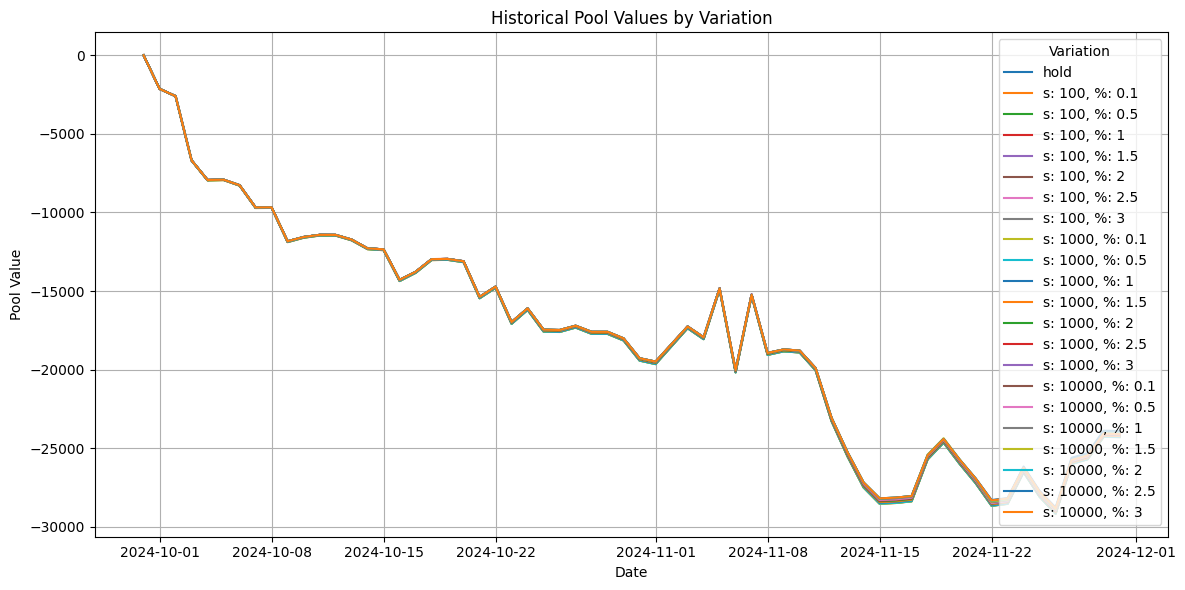

In [257]:
if False:
    # Print the updated list of matrices
    for matrix in matrix_list:
        print(f"Updated Matrix for {matrix['pool_name']}:")
        print(matrix['data'])

# Initialize an empty DataFrame for the result matrix
result_matrix = None

# Iterate over the matrices in the matrix_list
for matrix in matrix_list:
    # Access the data of the current matrix
    data = matrix["data"]

    # If result_matrix is None, initialize it with the current matrix's data
    if result_matrix is None:
        result_matrix = data.copy()
    else:
        # Sum the values for columns with the same names
        result_matrix = result_matrix.add(data, fill_value=0)

if False:
    # Print the resulting matrix
    print("Result Matrix:")
    print(result_matrix)


# Plot the unified historical values for each variation
plt.figure(figsize=(12, 6))
for column in result_matrix.columns:
    plt.plot(result_matrix.index, result_matrix[column], label=column)

# Customize the plot
plt.title("Historical Pool Values by Variation")
plt.xlabel("Date")
plt.ylabel("Pool Value")
plt.legend(title="Variation")
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [258]:
print(f"Base asset: {base_asset}")

print("Starting table (V0):")
pretty_print_table(starting_table)
print("   Value:               ", f"{starting_table['value'].sum():,.4f}")
print()

#print(sim_table)

print("Hold table (VH):")
hold_table = starting_table.copy()
hold_table['spot'] = sim_table['spot']
hold_table['value'] = hold_table['balance'] / hold_table['spot']
pretty_print_table(hold_table)
print("   Value:               ", f"{hold_table['value'].sum():,.4f}")
print()

print("Summary: ")
#print(results_df)
pretty_print_table(results_df)

#print()
#print(historical_values_df)

if False:
  print()
  print()
  print("End tables:")
  table_index = 1
  for result, table in zip(results, result_tables):
      # Print the summary for the table
      print(f"    Table: {table_index}")
      table_index += 1
      print(json.dumps(result, indent=4))
      # Print the table
      pretty_print_table(table)
      print("   Value:               ", f"{table['value'].sum():,.4f}")

Base asset: USD
Starting table (V0):
       weight    spot        value      balance
asset                                          
USD    0.5000  1.0000  30,652.2800  30,652.2800
NZD    0.5000  1.5753  30,652.2800  48,286.5154
   Value:                61,304.5600

Hold table (VH):
       weight    spot        value      balance
asset                                          
USD    0.5000  1.0000  30,652.2800  30,652.2800
NZD    0.5000  1.6889  28,590.4458  48,286.5154
   Value:                59,242.7258

Summary: 
     Order Size   Fee % Final_Pool_Value     Fees    Trades
0      100.0000  0.1000      59,219.7772  12.9945  130.0000
1      100.0000  0.5000      59,217.3482  10.4761   21.0000
2      100.0000  1.0000      59,219.4767  11.8881   12.0000
3      100.0000  1.5000      59,223.1577  16.2654   11.0000
4      100.0000  2.0000      59,228.5707  21.5877   11.0000
5      100.0000  2.5000      59,231.3915  24.4245   10.0000
6      100.0000  3.0000      59,233.8816  26.2271    9.0